In [1]:
# IMPORTS

# from GridClass import *
from GridClass_COPY_main import *

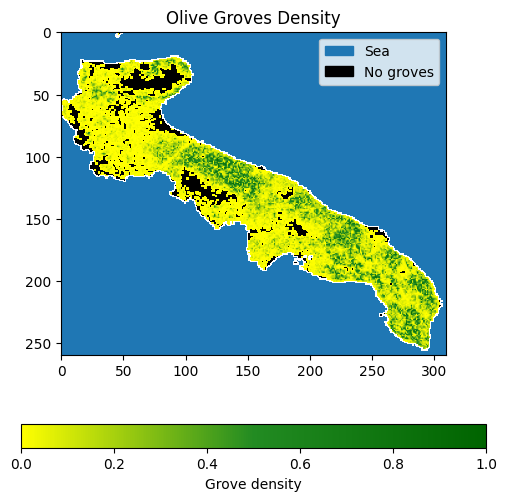

In [2]:
np.random.seed(100)

# GRID INSTANCE INITIALIZATION PARAMETERS
FROM_FILE = True
ROWS = 10 # Random grid
COLS = 10 # Random grid

# CREATE OLIVE GROVE DENSITY, FROM FILE OR RANDOMLY GENERATED
if FROM_FILE:
    file_path = "olivegrowthprop.mat"
    mat = sp.io.loadmat(file_path)
    GRID = Grid(density=mat["olivegrowthprop"])

else:
    GRID = Grid(shape=(ROWS, COLS))

# PLOT DISTRIBUTION OF OLIVE GROVES
GRID.plot_density(figsize=(6,6))

In [3]:
# SIMULATION PARAMETERS
# Control zone parameters
control = True
EZW = 10
BZW = 20
BZ_eff = 0.9

# Common parameters
A = 3 # 3 kp rate of population growth
B = 14.069
a = 0 # relative carrying capacity in non olive plants
tol = 1e-8 # 1e-8 numerical noise tolerance (IF TOLERANCE IS TOO BIG, IT CAN HAPPEN THAT THE SIMULATION IS TRUNCATED AT THE FIRST ITERATION)

# Dispersal type
dispersal_type = "short_long" # Levy flight jumps 
# dispersal_type = "short_long" # Short + long kernel (White, 2017)

# Short distance kernel
beta = 0.1
kernel_type = "exponential"

# Long distance kernel
disp_tol = 0.2 # 0.2 strattol stratified dispersal tolerance (threshold probability)
M_max = 5 # 5 maximum number of dispersers
D = 20 # 20 dispersal standard deviation

# Levy flight
n_vectors = 1000 # if vector_pop is True, this is not used
d_min = 0.1
d_max = 50 # None
alpha = 1.5
sample = "power"
vector_pop = False

# Vector population dynamics
max_vectors_per_cell = 50
birth_rate = 0.9
death_rate = 0.3

# Define parameter dictionary case by case
parameters = {'control_zone': [control, EZW, BZW, BZ_eff],
              'common': [A, B, a, tol],
              'dispersal': [dispersal_type],
              'short_long': [beta, kernel_type, disp_tol, M_max, D],
              'levy_flight': [n_vectors, d_min, d_max, alpha, sample, vector_pop],
              'vector_pop_dynamics': [max_vectors_per_cell, birth_rate, death_rate]}


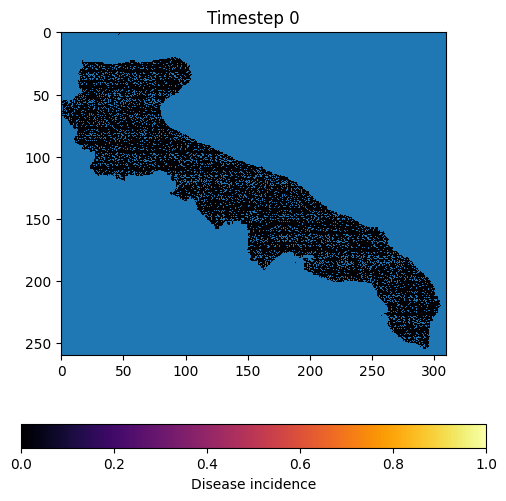

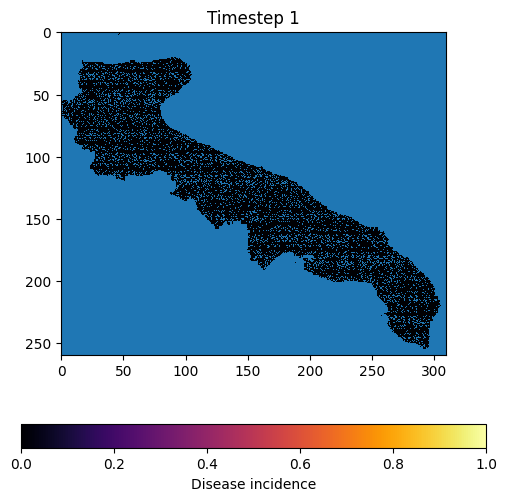

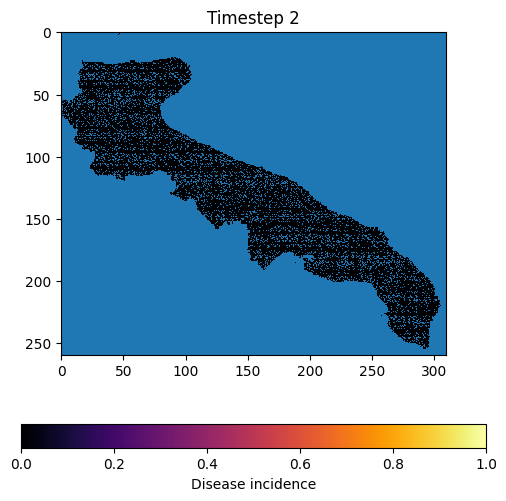

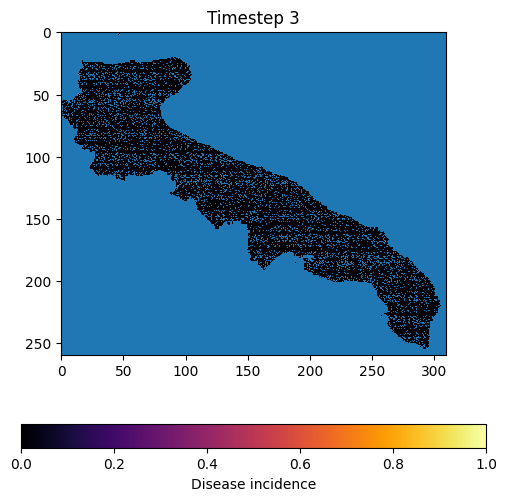

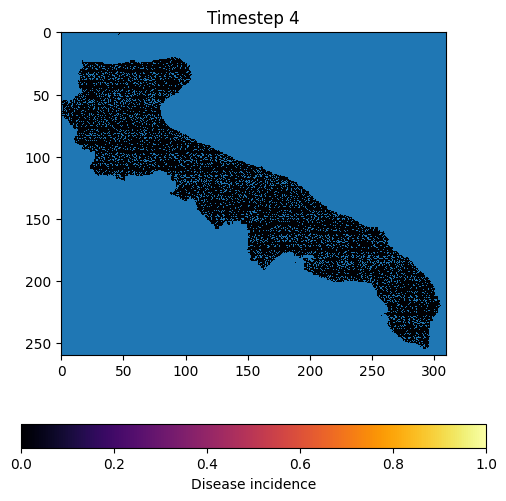

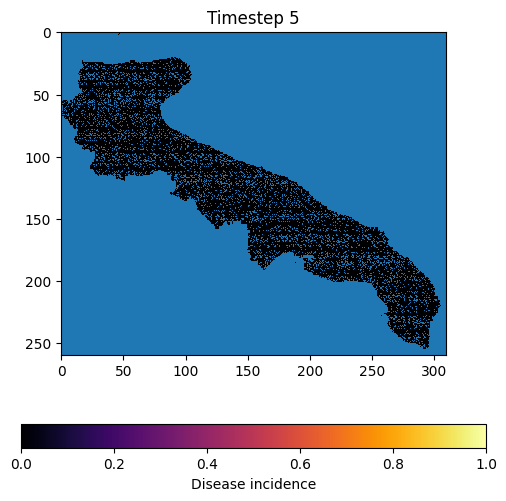

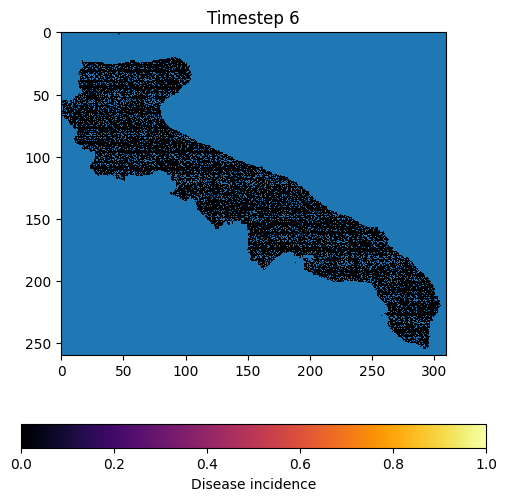

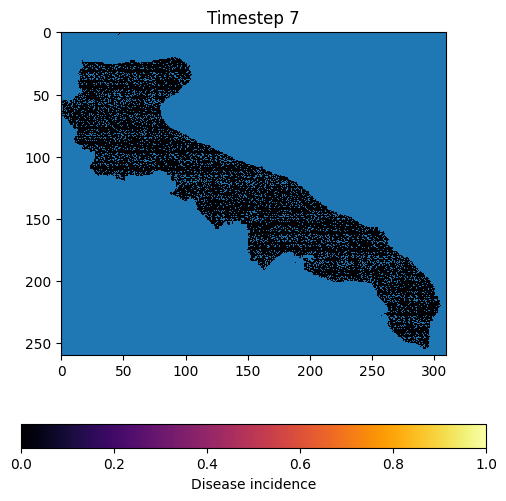

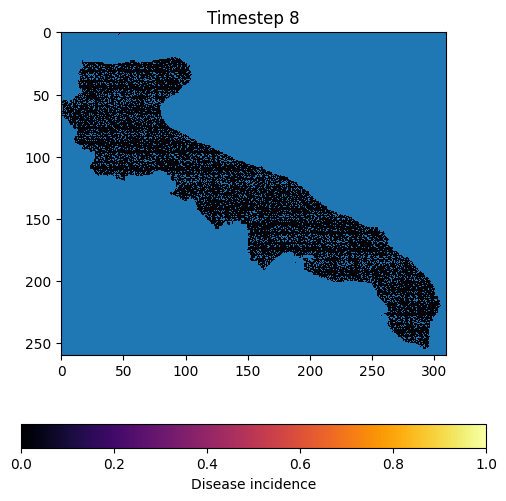

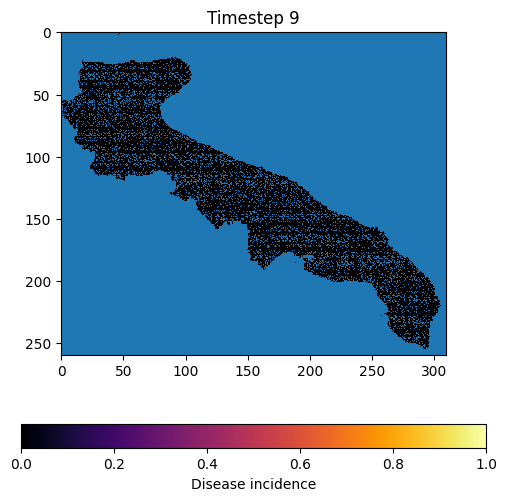

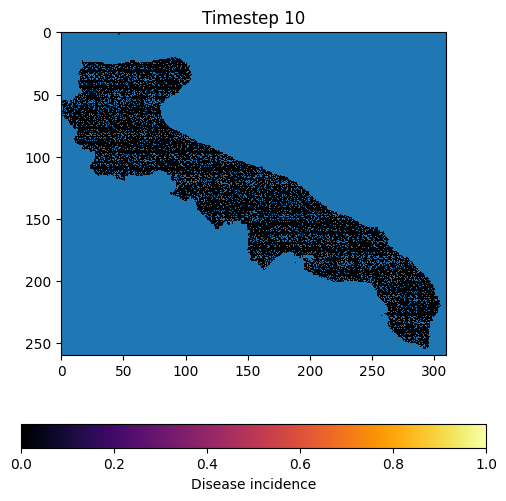

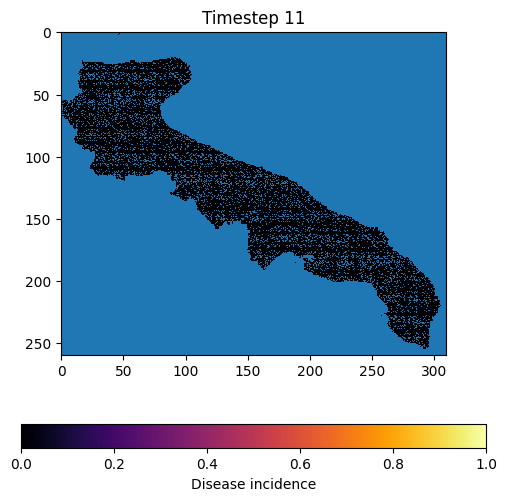

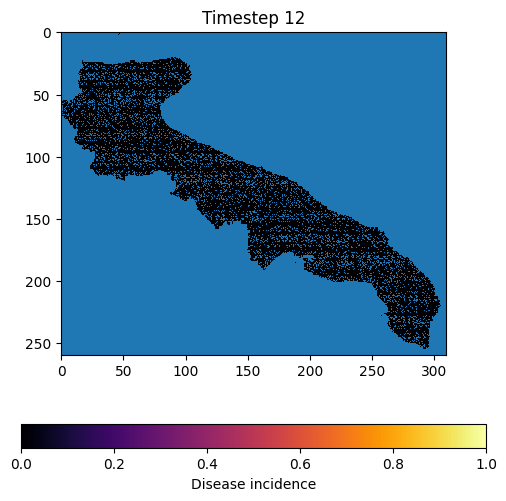

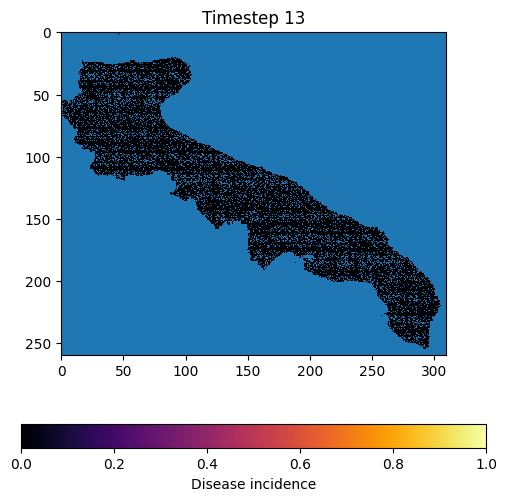

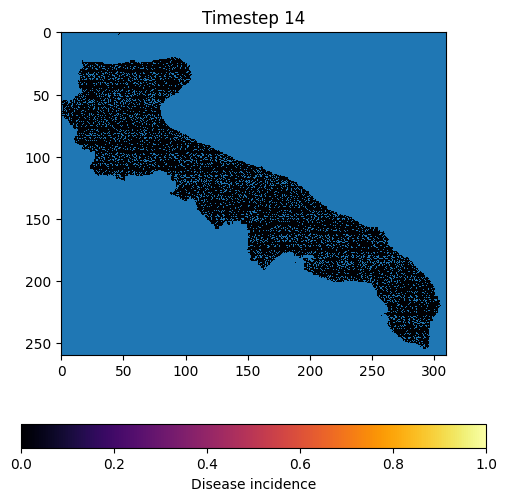

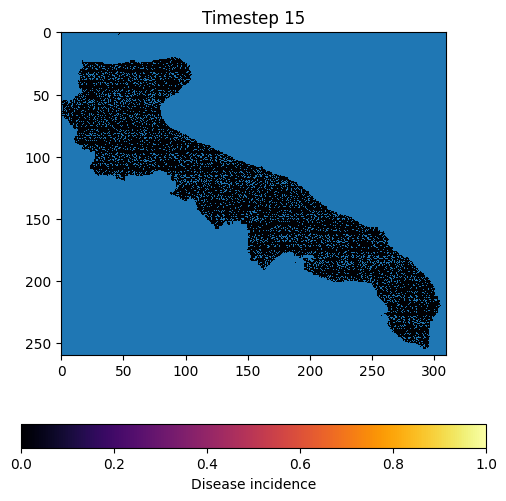

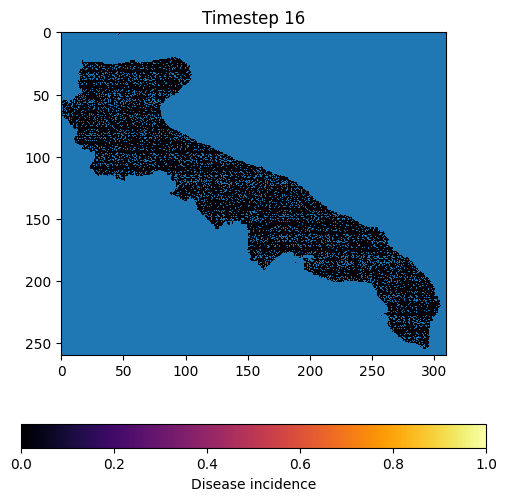

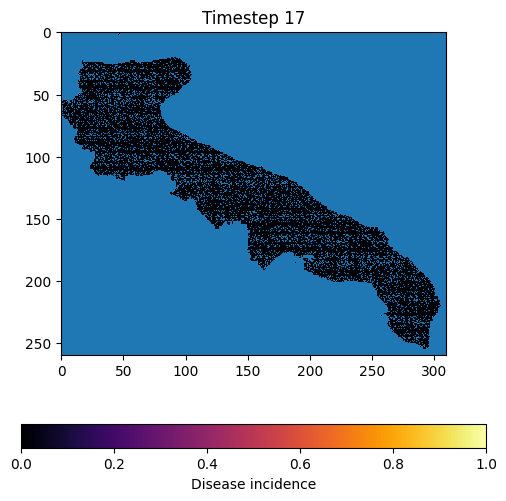

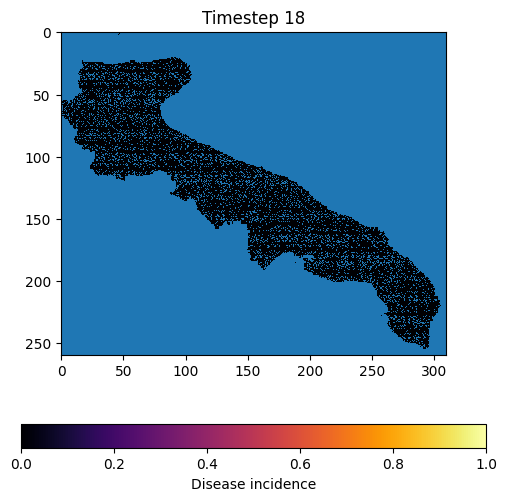

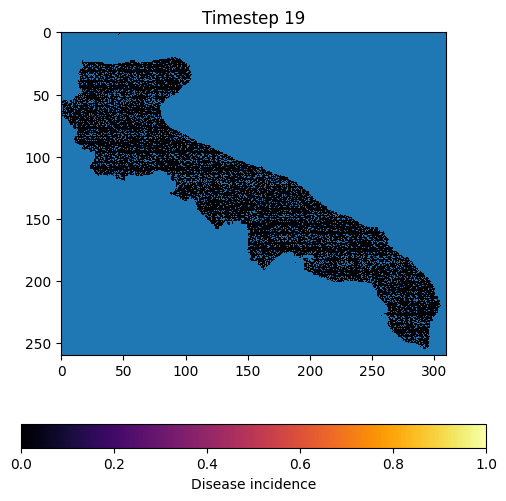

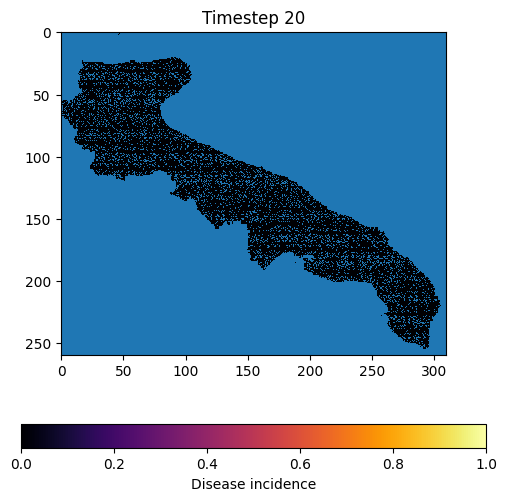

In [4]:
# RUN SIMULATION AND PLOT OUTCOME

# np.random.seed(5)

timesteps = 20

GRID.simulate(timesteps, parameters)
GRID.plot_incidence(figsize=(6,6))
# GRID.plot_final_incidence(figsize=(6,6))

In [11]:
n_vectors = 1
C = 13
birth_rate = 0.9
death_rate = 0.3
birth_rate * n_vectors * (1 - n_vectors / C) - death_rate * n_vectors

0.5307692307692309

In [21]:
# Example: max 10 vectors per cell. 
# These 10 have to be multiplied by the grove density to obtain the maximum for the cell.
# This proportion has to be multiplied by the proportion of infected grove density, to get the disease-spreading vectors.

In [22]:
max_vectors_per_cell = 30
max_total_vectors = (GRID.density[GRID.grove_mask] * max_vectors_per_cell).sum()
print(f'Total vectors on grid: {max_total_vectors}')
max_total_inf_vectors = (GRID.I[GRID.grove_mask] * max_vectors_per_cell).sum()
print(f'Total infectious vectors on grid: {max_total_inf_vectors}')

Total vectors on grid: 65251.28626412486
Total infectious vectors on grid: 20510.97605746243


In [78]:
GRID.seed
I = GRID.K[tuple(GRID.seed)] * np.exp(-GRID.B)
max_vectors = 30
n_vectors = max_vectors * GRID.density[tuple(GRID.seed)]
print(n_vectors)
n_inf_vectors = n_vectors * I
print(n_inf_vectors)
I = GRID.K[tuple(GRID.seed)] ** (1 - np.exp(-GRID.A)) * (I ** np.exp(-GRID.A)) 
print(I)
n_inf_vectors = n_vectors * I
print(n_inf_vectors)

7.5113452692206195
1.4595706783433852e-06
0.12427765461626775
0.9334923730717368


In [63]:
unique_vector_positions = np.unique(GRID.vector_positions, axis=0)
print(unique_vector_positions)

row_indices = unique_vector_positions[:, 0]
col_indices = unique_vector_positions[:, 1]

extracted_density = GRID.density[row_indices, col_indices]
n_occupied_cells = len(unique_vector_positions)
print(n_occupied_cells)
extracted_I = GRID.I[row_indices, col_indices]

# print(extracted_density.mean())
# print(extracted_I.mean())

(extracted_density - extracted_I).sum()
# (extracted_density.mean() - extracted_I.mean()) * n_occupied_cells

[[160 259]
 [172 224]
 [172 263]
 ...
 [254 294]
 [255 290]
 [255 292]]
1613


50.33179043613887

In [5]:
# EVALUATE RISK

N = 5
timesteps = 10
GRID.evaluate_risk(N, timesteps, parameters)

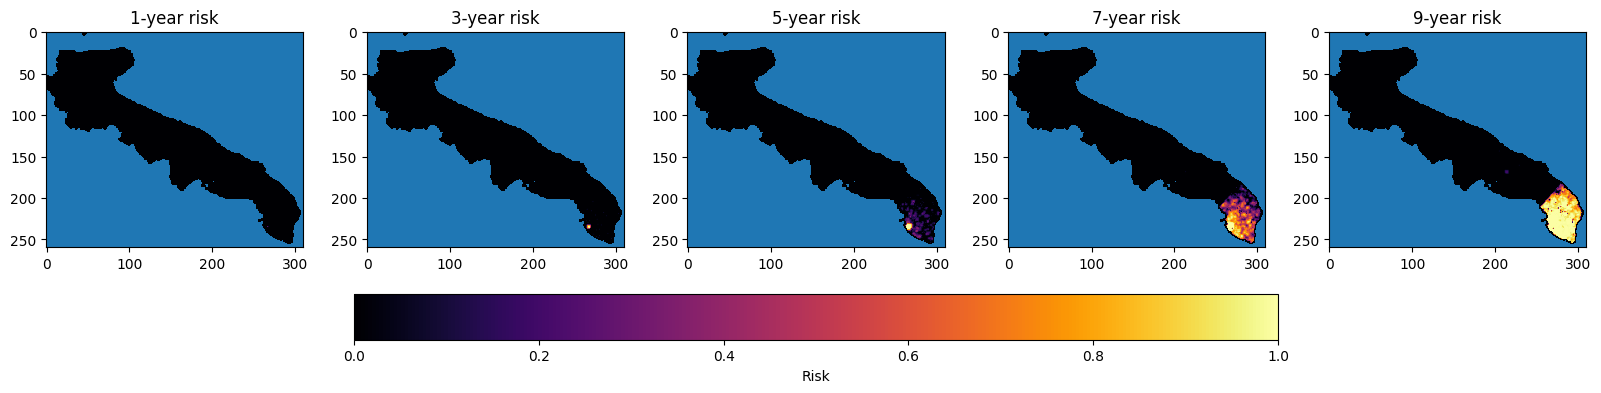

In [6]:
# PLOT RISK AT DIFFERENT TIMES

im_sea = np.ma.array(GRID.density, mask=~GRID.sea_mask)

ncols = 5
images = []
fig, ax = plt.subplots(1, ncols, figsize=(ncols*4,4))
for i in range(ncols):
    images.append(ax[i].imshow(GRID.risk[1+2*i], cmap="inferno", interpolation=None, norm=colors.Normalize(vmin=0, vmax=1)))
    ax[i].imshow(im_sea, cmap=colors.ListedColormap(['tab:blue']), interpolation=None)
    ax[i].set_title(f"{1+2*i}-year risk")
cbar = fig.colorbar(images[0], ax=ax, orientation="horizontal")
cbar.set_label("Risk")

plt.show()

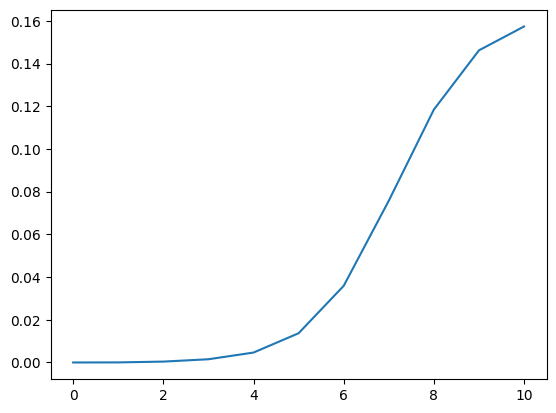

In [7]:
# EVALUATE RISK (AVERAGE INCIDENCE) OVER GRID TIMESERIES
# Short_long kernel with and without Control Zone

average = np.zeros(GRID.timesteps+1)

for t in range(GRID.timesteps+1):
    average[t] = GRID.risk[t][GRID.grove_mask].mean()
    
plt.plot(np.arange(GRID.timesteps+1), average)
plt.show()

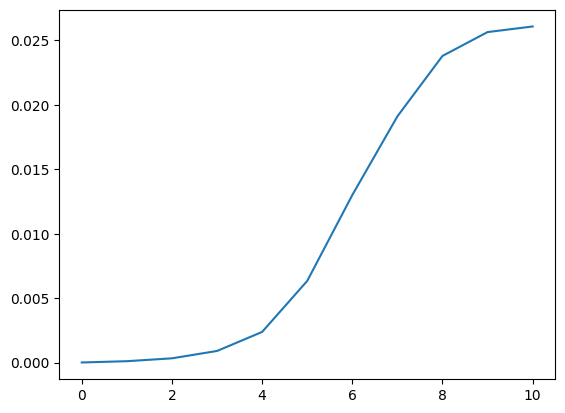

In [8]:
# PERCENTAGE OF GROVES THAT ARE INFECTED (ASSUMING 1 GROVE=1 GRID CELL)
# The Gompertz growth model grows very quickly even extremely small numbers.
# One year (one iteration) is typically enough to have a sizable value for I (incidence)
# So I will coansider as infected, all those groves above the tolerance value 'tol'

percentage_of_groves = np.zeros(GRID.incidence.shape[0])

for t in range(GRID.timesteps+1):
    percentage_of_groves[t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())

plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves)

plt.show()

In [9]:
# RUN SIMULATION FOR DIFFERENT PARAMETERS

N = 10
timesteps = 10
EZW_list = [10, 20, 30]
percentage_of_groves = np.zeros((len(EZW_list), GRID.timesteps+1))
# print(percentage_of_groves.shape)

for i, EZW in enumerate(EZW_list):
    parameters = {'control_zone': [control, EZW, BZW, BZ_eff],
                  'common': [A, B, a, tol],
                  'dispersal': [dispersal_type],
                  'short_long': [beta, kernel_type, disp_tol, M_max, D],
                  'levy_flight': [n_vectors, d_min, d_max, alpha, sample]}

    # GRID.simulate(timesteps, parameters)
    GRID.evaluate_risk(N, timesteps, parameters)
    # GRID.plot_density(figsize=(6,6))
    # GRID.plot_final_incidence(figsize=(6,6))

    for t in range(GRID.timesteps+1):
        # percentage_of_groves[i,t] = len(GRID.incidence[t][GRID.incidence[t] > tol]) / len(GRID.grove_mask.flatten())
        percentage_of_groves[i,t] = len(GRID.risk[t][GRID.risk[t] > tol]) / len(GRID.grove_mask.flatten())


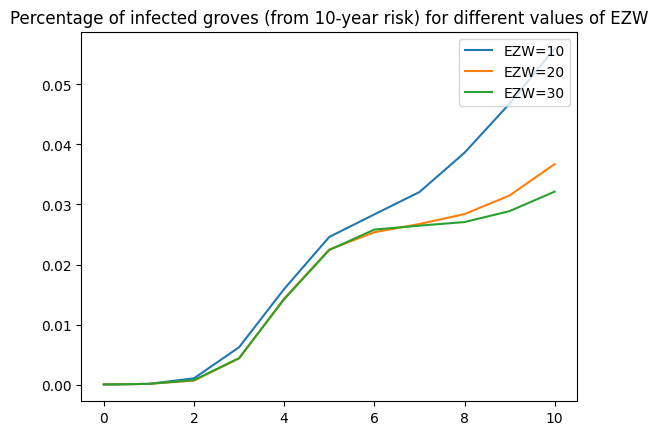

In [10]:
# PLOT PERCENTAGE OF INFECTED GROVES FOR DIFFERENT PARAMETER VALUES

for i, EZW in enumerate(EZW_list):
    plt.plot(np.arange(GRID.timesteps+1), percentage_of_groves[i], label=f'EZW={EZW}')

plt.legend(loc='upper right')
plt.title(f"Percentage of infected groves (from {timesteps}-year risk) for different values of EZW")
plt.show()

In [ ]:
# First interesting result: the size of the control zone determines a delay in the epidemic spread
# Explore different values for EZW and BZW
# Calculate time delay from simulation
# The increase in average incidence and percentage of infected groves increases linearly with time
# This reflects a constant speed for the infection front

# Differences in this regard between short_long and levy_flight. Levy_flight needs more time to 
# resume same pace (?): verify.  

In [ ]:
# INCLUDE VECTOR POPULATION DYNAMICS

# Vector population dynamics: 
# include vector population carrying capacity: related to weeding
# probability of vector from dying: pesticides and other methods (fungi, ecc.)
# Apply weeding and pesticides to CZ (EZ + BZ) and the infected area (IZ), below the CZ: to see whether it is enough to stop the northern spread

# How reasonable is incuding vector population dynamics? I am using a small number of vectors.

# N(t) is the total 

# Olive trees would die after a couple years after being infected. Before that, they still produce sap and vectors can still feed off them. 
# In general the distribution of years neede for a tree to die is several years wide. Minimum 2-3 years to at most ~10 years?

In [ ]:
# EVALUATE SPEED OF EPIDEMIC SPREAD 

# Get the centroid of each grid cell. 
# Create distance classes:
# - 1 km radius around centroid of seed cell (includes all cells whose centroid is within the radius)
# - 1 km wide concentric rings around centroid of seed cell (same) 

In [ ]:
# ADD LATENCY TIME: SEIR MODEL (without the 'R')
# Incubation period can be from 7 months to more than a year: https://www.fao.org/in-action/saving-mediterranean-olives/en/#:~:text=Xylella%20fastidiosa%3A%20a%20spreading%20threat&text=The%20disease%20is%20difficult%20to,to%20more%20than%20a%20year

In [ ]:
# REPLANTING????

In [ ]:
# TRY WITH DIFFERENT KERNELS
# EXPONENTIAL
# GAUSSIAN (BROWNIAN MOTION OF VECTORS)
# POWER LAW (LEVY JUMP)

In [ ]:
# ELIMINATE ERADICATION ZONE

In [ ]:
# add "scale" parameter for rescaling of random samples; resolved by simply modifying alpha exponent parameter
